In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import  transforms
from torchvision import models
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from sklearn.metrics import confusion_matrix

In [3]:
# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomRotation(degrees=10),
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Path to your data directory
data_dir = 'Sets'

# Load data from directories, focusing on 'Play' and 'Time_Between' classes only
def filter_classes(dataset, classes_to_include):
    # Filter samples
    filtered_samples = [(path, label) for path, label in dataset.samples if dataset.classes[label] in classes_to_include]
    
    # Reassign targets and samples
    new_targets = []
    new_samples = []
    class_to_idx = {cls: idx for idx, cls in enumerate(classes_to_include)}
    
    for path, label in filtered_samples:
        class_name = dataset.classes[label]
        if class_name in class_to_idx:
            new_label = class_to_idx[class_name]
            new_samples.append((path, new_label))
            new_targets.append(new_label)
    
    dataset.samples = new_samples
    dataset.targets = new_targets
    dataset.classes = classes_to_include
    dataset.class_to_idx = class_to_idx

# Apply the filter to each dataset split
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
for phase in ['train', 'val', 'test']:
    filter_classes(image_datasets[phase], ['Play', 'Time_Between'])

# Check dataset sizes and class names
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# Print dataset sizes and class names
print("Filtered dataset sizes:", dataset_sizes)
print("Filtered classes:", class_names)

# Print number of frames for each class in each dataset
for phase in ['train', 'val', 'test']:
    print(f"\n{phase.upper()} dataset:")
    class_counts = {class_name: 0 for class_name in class_names}
    for _, label in image_datasets[phase].samples:
        class_name = class_names[label]
        class_counts[class_name] += 1
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} frames")

Filtered dataset sizes: {'train': 316795, 'val': 56903, 'test': 63966}
Filtered classes: ['Play', 'Time_Between']

TRAIN dataset:
  Play: 128701 frames
  Time_Between: 188094 frames

VAL dataset:
  Play: 23801 frames
  Time_Between: 33102 frames

TEST dataset:
  Play: 26188 frames
  Time_Between: 37778 frames


In [4]:
from collections import defaultdict

def balance_and_reduce_sequences(dataset, seq_length, max_frames_per_class):
    class_counts = defaultdict(list)
    for idx, (path, label) in enumerate(dataset.samples):
        class_name = dataset.classes[label]
        class_counts[class_name].append((path, label))

    max_sequences_per_class = max_frames_per_class // seq_length

    balanced_samples = []
    for class_name in class_counts:
        samples = class_counts[class_name][:max_sequences_per_class * seq_length]
        balanced_samples.extend(samples)

    dataset.samples = balanced_samples
    dataset.targets = [label for _, label in balanced_samples]
    print(f"Balanced and reduced {len(balanced_samples)} samples for dataset.")

class VideoDataset(Dataset):
    def __init__(self, image_folder_dataset, seq_length, transform=None):
        self.image_folder_dataset = image_folder_dataset
        self.seq_length = seq_length
        self.transform = transform
        self.valid_sequences = self.prepare_sequences()
        print(f"Prepared {len(self.valid_sequences)} valid sequences.")

    def prepare_sequences(self):
        grouped_frames = defaultdict(list)
        for path, label in self.image_folder_dataset.samples:
            video_name, frame_number = self.parse_frame_details(path)
            grouped_frames[video_name].append((int(frame_number), path, label))

        valid_sequences = []
        for frames in grouped_frames.values():
            frames.sort()  # Sortiere Frames nach ihrer Nummer
            # Hier generieren wir überlappende Sequenzen
            for i in range(len(frames) - self.seq_length + 1):  # Erlaubt Überlappung
                # Extra check to ensure continuity
                if frames[i + self.seq_length - 1][0] - frames[i][0] == self.seq_length - 1:
                    sequence = [(frame[1], frame[2]) for frame in frames[i:i + self.seq_length]]
                    valid_sequences.append(sequence)
        return valid_sequences

    def parse_frame_details(self, path):
        basename = os.path.basename(path)
        parts = basename.split('_')
        video_name = '_'.join(parts[:-2])
        frame_number = parts[-1].split('.')[0]
        return video_name, frame_number

    def __len__(self):
        return len(self.valid_sequences)

    def __getitem__(self, idx):
        frame_paths, labels = zip(*self.valid_sequences[idx])
        images = [self.load_transform_image(path) for path in frame_paths]
        images = torch.stack(images)
        labels = torch.tensor(labels)  # Behalten Sie alle Labels bei
        return images, labels


    def load_transform_image(self, path):
        img = self.image_folder_dataset.loader(path)
        if self.transform:
            img = self.transform(img)
        return img

seq_length = 30
max_frames_train = 3000
max_frames_val_test = 450

# Assume image_datasets and data_transforms are defined somewhere else
balance_and_reduce_sequences(image_datasets['train'], seq_length, max_frames_train)
balance_and_reduce_sequences(image_datasets['val'], seq_length, max_frames_val_test)
balance_and_reduce_sequences(image_datasets['test'], seq_length, max_frames_val_test)

video_datasets = {x: VideoDataset(image_datasets[x], seq_length, data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(video_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val', 'test']}

# Print number of sequences in each set
for key, dataset in video_datasets.items():
    print(f"{key.upper()} dataset: {len(dataset)} sequences")

Balanced and reduced 6000 samples for dataset.
Balanced and reduced 840 samples for dataset.
Balanced and reduced 840 samples for dataset.
Prepared 5181 valid sequences.
Prepared 718 valid sequences.
Prepared 658 valid sequences.
TRAIN dataset: 5181 sequences
VAL dataset: 718 sequences
TEST dataset: 658 sequences


In [5]:
# Check if CUDA is available and use it if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class CNN_LSTM(nn.Module):
    def __init__(self, cnn_model, hidden_size, num_classes=2, num_layers=1):
        super(CNN_LSTM, self).__init__()
        self.cnn = cnn_model
        self.lstm = nn.LSTM(input_size=2048, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size, seq_length, C, H, W = x.size()
        c_in = x.view(batch_size * seq_length, C, H, W)
        c_out = self.cnn(c_in)
        c_out = c_out.view(batch_size, seq_length, -1)

        r_out, _ = self.lstm(c_out)
        r_out = self.fc(r_out)
        return r_out

# Configuration of the model parameters
resnet = models.resnet50(pretrained=True)
cnn_model = nn.Sequential(*list(resnet.children())[:-2], nn.MaxPool2d(kernel_size=7, stride=7))
hidden_size = 128
num_classes = 2
num_layers = 1

cnn_lstm_model = CNN_LSTM(cnn_model, hidden_size, num_classes, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(cnn_lstm_model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

Using device: cuda:0


c:\Users\MCI\anaconda3\envs\football_analysis\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MCI\anaconda3\envs\football_analysis\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=35, dataloaders=None, batch_update_interval=50):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print("Training start")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            all_labels = []
            all_preds = []

            batch_count = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = outputs.transpose(1, 2)  # Anpassung der Output-Dimensionen für CrossEntropyLoss

                    # Flatten labels to match the flattened outputs
                    labels = labels.reshape(-1)  # [batch_size * seq_length]

                    # Die Outputs umformen, um zu den Labels zu passen
                    loss = criterion(outputs.reshape(-1, outputs.size(-2)), labels)

                    _, preds = torch.max(outputs, 1)  # Maximalen log-Wahrscheinlichkeitsindex finden
                    preds = preds.reshape(-1)  # Flatten predictions

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

                # Labels und Vorhersagen für die Konfusionsmatrix sammeln
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

                batch_count += 1
                if batch_count % batch_update_interval == 0:
                    print(f'Batch {batch_count}/{len(dataloaders[phase])} - {phase} Loss: {running_loss / (batch_count * inputs.size(0)):.4f} Acc: {running_corrects.double() / (batch_count * inputs.size(0) * inputs.size(1)):.4f}')

            if phase == 'train':
                scheduler.step()  # Lernratenplaner schrittweise anpassen

            # Epocheverlust und -genauigkeit berechnen
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / (len(dataloaders[phase].dataset) * inputs.size(1))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Konfusionsmatrix für die Validierungsphase drucken
            if phase == 'val':
                cm = confusion_matrix(all_labels, all_preds)
                print(f'Confusion Matrix for epoch {epoch}:\n{cm}')

            # Die besten Modellgewichte kopieren und das Modell speichern, wenn es die beste Genauigkeit hat
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, 'best_model.pth')

        print()

    # Gesamte Trainingsdauer berechnen
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Die besten Modellgewichte laden
    model.load_state_dict(best_model_wts)
    return model

# Instantiate the criterion for multi-class classification
criterion = nn.CrossEntropyLoss()

# Train and evaluate the model with live updates and confusion matrix printing
model_ft = train_model(cnn_lstm_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=35, dataloaders=dataloaders)


Training start
Epoch 0/49
----------
Batch 50/648 - train Loss: 0.6937 Acc: 0.5089
Batch 100/648 - train Loss: 0.6932 Acc: 0.4847
Batch 150/648 - train Loss: 0.6931 Acc: 0.4911
Batch 200/648 - train Loss: 0.6928 Acc: 0.4836
Batch 250/648 - train Loss: 0.6923 Acc: 0.4812
Batch 300/648 - train Loss: 0.6917 Acc: 0.5040
Batch 350/648 - train Loss: 0.6907 Acc: 0.5368
Batch 400/648 - train Loss: 0.6895 Acc: 0.5683
Batch 450/648 - train Loss: 0.6881 Acc: 0.5957
Batch 500/648 - train Loss: 0.6862 Acc: 0.6226
Batch 550/648 - train Loss: 0.6834 Acc: 0.6512
Batch 600/648 - train Loss: 0.6796 Acc: 0.6767
train Loss: 0.6741 Acc: 0.6870
Batch 50/90 - val Loss: 0.7206 Acc: 0.5493
val Loss: 0.7176 Acc: 0.5695
Confusion Matrix for epoch 0:
[[10952 12478]
 [ 6067 13583]]

Epoch 1/49
----------
Batch 50/648 - train Loss: 0.6898 Acc: 0.4763
Batch 100/648 - train Loss: 0.6670 Acc: 0.5389
Batch 150/648 - train Loss: 0.6479 Acc: 0.5484
Batch 200/648 - train Loss: 0.6321 Acc: 0.5667
Batch 250/648 - train Loss

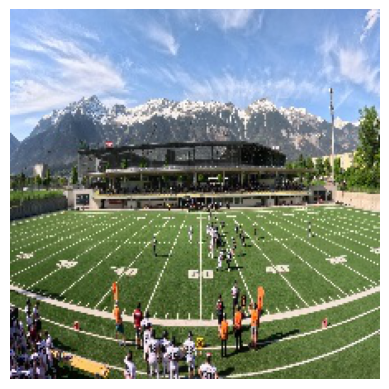

In [8]:
from PIL import Image

def load_and_normalize_image(image_path):
    # Bild laden
    input_image = Image.open(image_path)

    # Transformation definieren
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Bild auf 224x224 skalieren, falls es nicht die Maße hat
        transforms.ToTensor(),  # Konvertiert das Bild zu einem Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisieren
    ])

    # Bild transformieren
    normalized_image = transform(input_image)
    
    return normalized_image

def show_image(tensor):
    # Den Tensor für die Anzeige umformen
    image = tensor.numpy().transpose((1, 2, 0))
    # Mittelwert und Standardabweichung zum Rückgängigmachen der Normalisierung
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    # Bildkorrrekturen für korrekte Anzeige
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')  # Keine Achsen für ein klareres Bild
    plt.show()

# Bildpfad (ersetze 'path_to_your_image.jpg' mit dem Pfad zu deinem Bild)
image_path = 'GX020050_frame_902_Normalized.jpg'
normalized_image = load_and_normalize_image(image_path)
show_image(normalized_image)

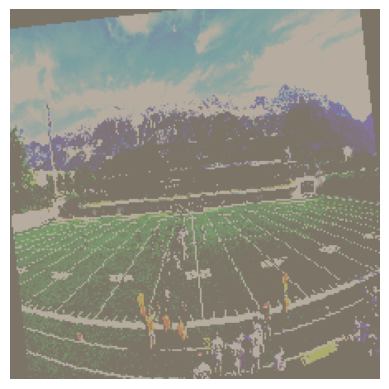

In [10]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def load_and_normalize_image(image_path):
    # Bild laden
    input_image = Image.open(image_path)

    # Transformation definieren
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Bild auf 224x224 skalieren
        transforms.ToTensor(),  # Konvertiert das Bild zu einem Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisieren
    ])

    # Bild transformieren
    normalized_image = transform(input_image)
    
    return normalized_image

def augment_image(tensor):
    # Augmentierungstransformationen definieren
    augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # Zufällige horizontale Spiegelung
        transforms.RandomRotation(degrees=10),  # Zufällige Rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)  # Farbanpassung
    ])

    # Augmentiertes Bild erzeugen
    augmented_image = augmentation(tensor)
    return augmented_image

def show_image(tensor):
    # Den Tensor für die Anzeige umformen
    image = tensor.numpy().transpose((1, 2, 0))
    # Mittelwert und Standardabweichung zum Rückgängigmachen der Normalisierung
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    # Bildkorrrekturen für korrekte Anzeige
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')  # Keine Achsen für ein klareres Bild
    plt.show()

# Bildpfad (ersetze 'path_to_your_image.jpg' mit dem Pfad zu deinem Bild)
'GX020050_frame_902_Normalized.jpg'
normalized_image = load_and_normalize_image(image_path)
augmented_image = augment_image(normalized_image)
show_image(augmented_image)
